##**Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import os

# Sastrawi
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE'

###**Data Gathering**

In [ ]:
dataset1 = [
    'dataset_cnn_summarized.csv',
    'dataset_kompas_summarized.csv',
    'dataset_tempo_summarized.csv',
    'dataset_turnbackhoax_summarized.csv'
]

#  Inisialisasi dataframe kosong untuk menampung hasil gabungan
df_political_news = pd.DataFrame()

#  Membaca dan menggabungkan file-file dataset 1
for file in dataset1:
  file_path = os.path.join(drive_path, file)
  if os.path.exists(file_path):
    try:
        # Add on_bad_lines='warn' and low_memory=False to handle parsing errors
        temp_df = pd.read_csv(file_path, sep=';', on_bad_lines='warn', low_memory=False)
        df_political_news = pd.concat([df_political_news, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading file {file}: {e}")
  else:
    print(f"File {file} tidak ditemukan di Google Drive. Silahkan periksa path nya")


# Dataset 2: Indonesia False News Dataset
try:
  df_false_news_train = pd.read_csv(os.path.join(drive_path, 'Data_latih.csv'))
  df_false_news_test = pd.read_csv(os.path.join(drive_path, 'Data_uji.csv'))
  df_false_news = pd.concat([df_false_news_train, df_false_news_test], ignore_index=True)
except FileNotFoundError:
  print("File dataset 2 tidak ditemukan di Google Drive. Silahkan periksa path nya ")
  df_false_news = pd.DataFrame()


In [ ]:
print(df_political_news.columns)

Index(['index', 'title', 'raw timestamp', 'original', 'tags', 'author', 'url',
       'cleaned', 'label', 'timestamp', 'cleaned token length', 'summarized',
       'politik', 'raw narasi'],
      dtype='object')


In [ ]:
print(df_false_news.columns)

Index(['ID', 'label', 'tanggal', 'judul', 'narasi', 'nama file gambar'], dtype='object')


In [ ]:
# Standarisasi kolom dan formal
if not df_political_news.empty:
    df_political_news_clean = df_political_news[['title', 'cleaned', 'label']].copy()
    df_political_news_clean = df_political_news_clean.rename(columns={
        'title': 'judul',
        'cleaned':'narasi',
        'label': 'label'
    })

if not df_false_news.empty:
  #Pilih dan rename kolom yang dibutuhkan dari dataset 2
  df_false_news_clean = df_false_news[['judul', 'narasi', 'label']].copy()

#Gabungkan kedua dataset
if not df_political_news.empty and not df_false_news.empty:
  df_combined = pd.concat([df_political_news_clean, df_false_news_clean], ignore_index=True)

  # Menyimpan dataset gabungan
  df_combined.to_csv('combined_hoax_dataset.csv', index=False)
  print(f"Dataset gabungan berhasil disimpan dengan {len(df_combined)} baris data")



Dataset gabungan berhasil disimpan dengan 36033 baris data


##**Data Understanding**

In [ ]:
df_combined.head()

,judul,narasi,label
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0.0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0.0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0.0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0.0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0.0


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36033 entries, 0 to 36032
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   judul   36033 non-null  object 
 1   narasi  32148 non-null  object 
 2   label   35563 non-null  float64
dtypes: float64(1), object(2)
memory usage: 844.7+ KB


In [ ]:
df_combined['label'] = pd.to_numeric(df_combined['label'], errors='coerce')  # Paksa float jadi numeric
df_combined = df_combined.dropna(subset=['label'])  # Hapus baris yang tidak ada labelnya
df_combined['label'] = df_combined['label'].astype(int)  # Ubah ke int

<ipython-input-11-a70a62ecde03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['label'] = df_combined['label'].astype(int)  # Ubah ke int


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35563 entries, 0 to 35562
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   judul   35563 non-null  object
 1   narasi  31678 non-null  object
 2   label   35563 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
# prompt: liat nilai unik ni kolom label

print(df_combined['label'].unique())

[0 1]



Distribusi Label:
label
0    21717
1    13846
Name: count, dtype: int64

Statistik Panjang Judul:
count    35563.000000
mean         9.879875
std          2.795984
min          1.000000
25%          8.000000
50%         10.000000
75%         11.000000
max         38.000000
Name: judul_length, dtype: float64

Statistik Panjang Narasi:
count    35563.000000
mean       159.598009
std        168.546515
min          1.000000
25%         23.000000
50%        134.000000
75%        252.000000
max       4167.000000
Name: narasi_length, dtype: float64

Jumlah Missing Values per Kolom:
judul               0
narasi           3885
label               0
judul_length        0
narasi_length       0
dtype: int64


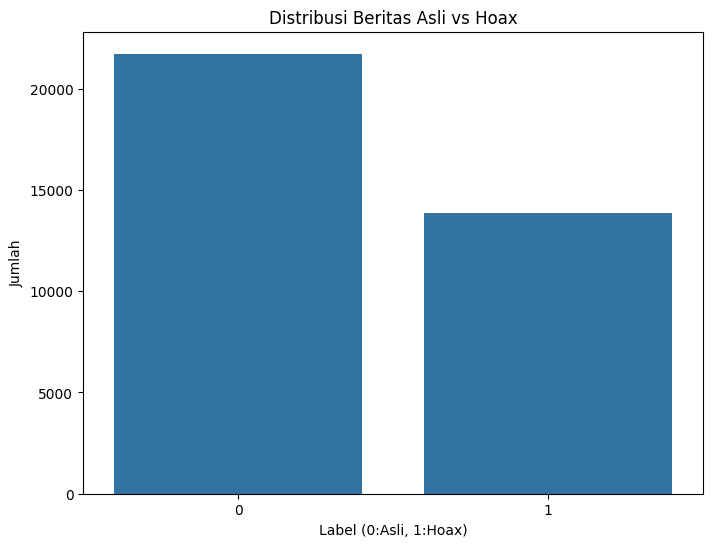

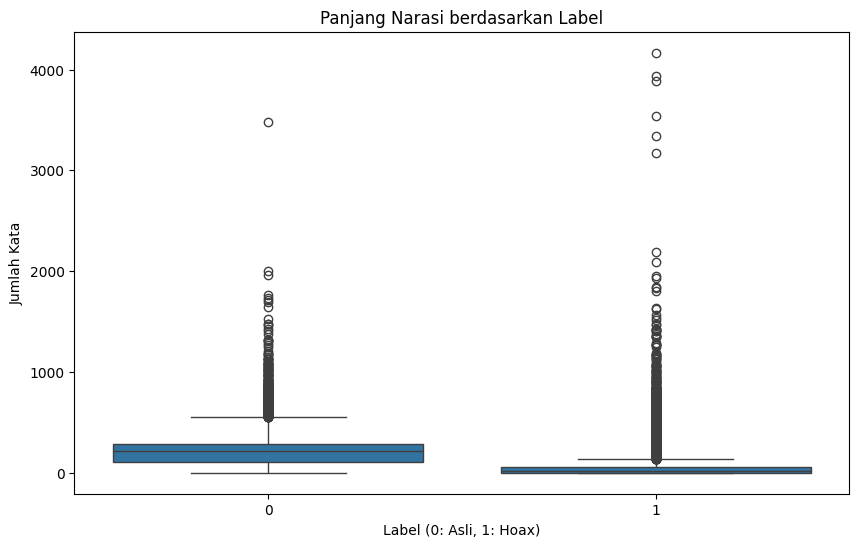

In [ ]:
if 'df_combined' in locals():
  #Distribusi label
  print("\nDistribusi Label:")
  label_counts = df_combined['label'].value_counts()
  print(label_counts)

  #Visualisasi distribusi label
  plt.figure(figsize=(8, 6))
  sns.countplot(x='label', data=df_combined)
  plt.title('Distribusi Beritas Asli vs Hoax')
  plt.xlabel('Label (0:Asli, 1:Hoax)')
  plt.ylabel('Jumlah')

  #Statistik panjang teks
  df_combined['judul_length']= df_combined['judul'].apply(lambda x: len(str(x).split()))
  df_combined['narasi_length']= df_combined['narasi'].apply(lambda x: len(str(x).split()))
  print("\nStatistik Panjang Judul:")
  print(df_combined['judul_length'].describe())

  print("\nStatistik Panjang Narasi:")
  print(df_combined['narasi_length'].describe())

  #Visualisasi panjang narasi berdasarkan label
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='label', y='narasi_length', data=df_combined)
  plt.title('Panjang Narasi berdasarkan Label')
  plt.xlabel('Label (0: Asli, 1: Hoax)')
  plt.ylabel('Jumlah Kata')


  # Memeriksa missing values
  print("\nJumlah Missing Values per Kolom:")
  print(df_combined.isnull().sum())


In [ ]:
rows_with_nan_narasi = df_combined[df_combined['narasi'].isnull()]
print("\nRows with NaN in 'narasi':")
rows_with_nan_narasi


Rows with NaN in 'narasi':


,judul,narasi,label,judul_length,narasi_length
9781,Anies Lunasi Utang ke Prabowo Terkait Pilkada ...,NaN,0,10,1
9792,Alasan Sandiaga Baru Ungkap Perjanjian Politik...,NaN,0,10,1
10220,Gaduhnya Panggung Politik Gegara Pidato Rambut...,NaN,0,8,1
10318,Respons PDI-P Terkait Pertemuan Anies dan Gibran,NaN,0,7,1
10377,PKB Tak Khawatir Ditolak PKS,NaN,0,5,1
...,...,...,...,...,...
31317,"(EDUKASI) : Harun Yahya, Salah Satu Pionir Hoa...",NaN,1,10,1
31318,(HOAX) : Bayi Nabila Meninggal Karena Kabut As...,NaN,1,10,1
31319,(HOAX) : Munculnya Bara Api di Yaman,NaN,1,7,1
31320,(EDUKASI) Bisnis Penjualan Fanpage,NaN,1,4,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['judul_length'].plot(kind='hist', bins=20, title='judul_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='label', y='judul_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['judul_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('judul_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label']
  ys = series['judul_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('judul_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['judul_length'].plot(kind='line', figsize=(8, 4), title='judul_length')
plt.gca().spines[['top', 'right']].set_visible(False)

##Data Preprocessing

In [ ]:
# Menghapus baris dengan nilai kosong atau NaN di kolom 'narasi'
df_combined.dropna(subset=['narasi'], inplace=True)

# Memeriksa kembali jumlah missing values setelah penghapusan
print("\nJumlah Missing Values per Kolom setelah menghapus baris dengan narasi kosong:")
print(df_combined.isnull().sum())

# Memeriksa jumlah baris setelah penghapusan
print(f"\nJumlah baris setelah menghapus baris dengan narasi kosong: {len(df_combined)}")


Jumlah Missing Values per Kolom setelah menghapus baris dengan narasi kosong:
judul            0
narasi           0
label            0
judul_length     0
narasi_length    0
dtype: int64

Jumlah baris setelah menghapus baris dengan narasi kosong: 31678


In [ ]:
# Fungsi membersihkan teks
def clean_text(text):
  if isinstance(text, str):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

# Casefolding Text
def casefoldingText(text):
  text = text.lower()
  return text

# Tokenizing Text
def tokenizingText(text):
  text = word_tokenize(text)
  return text

# Filtering Text
def filteringText(text):
  listStopwords = set(stopwords.words('indonesian'))
  listStopwords1 = set(stopwords.words('english'))
  listStopwords.update(['yang', 'dengan', 'ini', 'itu', 'atau', 'dan', 'dari', 'ke', 'di'])
  filtered = []
  for txt in text:
    if txt not in listStopwords:
      filtered.append(txt)
  text = filtered
  return text

#Stemming Text
def stemmingText(text):
  #Membuat objek stemmer
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  # Memecah teks menjadi daftar kata
  words = text.split()

  # Menerapkan stemming pada setiap kata dalam daftar
  stemmed_words = [stemmer.stem(word) for word in words]

  # Menggabungkan kata-kata yang telah distemming menjadi teks baru
  stemmed_text = ' '.join(stemmed_text)

  return stemmed_text

def toSentence(list_words):
  sentence = ' '.join(word for word in list_words)
  return sentence

In [ ]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
df_combined

,judul,narasi,label,judul_length,narasi_length
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,8,263
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,11,281
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,12,183
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,8,185
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,10,200
...,...,...,...,...,...
35558,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,1,9,8
35559,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,1,6,29
35560,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,1,9,6
35561,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,1,12,11


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Membersihkan teks dan menyimpan di kolom "text_Clean"
df_combined['text_clean'] = df_combined['narasi'].apply(clean_text)

#Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di "text_casefoldingText"
df_combined['text_casefoldingText'] = df_combined['text_clean'].apply(casefoldingText)

#Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di "text_slangwords"
df_combined['text_slangwords'] = df_combined['text_casefoldingText'].apply(fix_slangwords)

#Memecah teks menjadi token (kata-kata ) dan menyimpannya di "text_tokenizingText"
df_combined['text_tokenizingText'] = df_combined['text_slangwords'].apply(tokenizingText)

#Menghapus kata-kata stop dan menyimpannya di text_stopword"
df_combined['text_stopword'] = df_combined['text_tokenizingText'].apply(filteringText)

#Menggabungkan token" menjadi kalimat dan menyimapnnya di "text_akhir"
df_combined['text_akhir'] = df_combined['text_stopword'].apply(toSentence)



In [ ]:
df_combined.head()

,judul,narasi,label,judul_length,narasi_length,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,8,263,Anies di Milad BKMT Pengajian Menghasilkan Ibu...,anies di milad bkmt pengajian menghasilkan ibu...,anies di milad bkmt pengajian menghasilkan ibu...,"[anies, di, milad, bkmt, pengajian, menghasilk...","[anies, milad, bkmt, pengajian, menghasilkan, ...",anies milad bkmt pengajian menghasilkan ibuibu...
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,11,281,Edy Soal Pilgub Sumut Kalau yang Maju Abalabal...,edy soal pilgub sumut kalau yang maju abalabal...,edy soal pilgub sumut kalau yang maju abalabal...,"[edy, soal, pilgub, sumut, kalau, yang, maju, ...","[edy, pilgub, sumut, maju, abalabal, terpaksa,...",edy pilgub sumut maju abalabal terpaksa maju g...
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,12,183,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,pkb bakal daftarkan menaker ida fauziyah jadi ...,pkb bakal daftarkan menaker ida fauziyah jadi ...,"[pkb, bakal, daftarkan, menaker, ida, fauziyah...","[pkb, daftarkan, menaker, ida, fauziyah, caleg...",pkb daftarkan menaker ida fauziyah caleg dpr p...
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,8,185,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,gede pasek doakan ahy jadi capres atau cawapre...,gede pasek doakan ahy jadi capres atau cawapre...,"[gede, pasek, doakan, ahy, jadi, capres, atau,...","[gede, pasek, doakan, ahy, capres, cawapres, k...",gede pasek doakan ahy capres cawapres ketua pa...
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,10,200,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,pkn siapkan jabatan khusus buat anas urbaningr...,pkn siapkan jabatan khusus buat anas urbaningr...,"[pkn, siapkan, jabatan, khusus, buat, anas, ur...","[pkn, siapkan, jabatan, khusus, anas, urbaning...",pkn siapkan jabatan khusus anas urbaningrum be...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df_combined.to_csv('preprocessed_hoax_dataset.csv', index=False)
print(f"Dataset yang telah dipreprocessing berhasil disimpan dengan {len(df_combined)} baris data")

Dataset yang telah dipreprocessing berhasil disimpan dengan 31678 baris data
